In [1]:
from asyncio.windows_events import NULL
import os
from PIL.Image import ID
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import PlottingFunctions as pf
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from time import perf_counter
# %matplotlib widget

In [2]:
def load_object(filename):
    '''
    load an object from a file using the built-in pickle library

    :param filename: Name of the file from which to load data
    '''
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

def pad_to_length(short_arr, target_length):
    """
    Given short_arr of shape (m, d), return a new array of shape (target_length, d)
    whose first (target_length - m) rows are NaN and whose last m rows are short_arr.
    """
    m, d = short_arr.shape
    if m == target_length:
        return short_arr.copy()
    elif m > target_length:
        raise ValueError(f"short_arr has more rows ({m}) than target_length ({target_length}).")
    # create a (target_length, d) array full of NaNs
    padded = np.full((target_length, d), np.nan, dtype=short_arr.dtype)
    # put the original data into the last m rows
    padded[-m :, :] = short_arr
    return padded

In [3]:
def XYZoverTime(pos_r, pos_i, pos_p, labels=['real', 'integral', 'prediction'], marker=['b-', 'r--', 'g,']):
    plt.rcParams["figure.figsize"] = (14,10)
    plt.subplot(3,1,1)
    plt.plot(pos_r[:,0], marker[0], label=labels[0])
    plt.plot(pos_i[:,0], marker[1], label=labels[1])
    plt.plot(pos_p[:,0], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('X')
    plt.grid()
    plt.subplot(3,1,2)
    plt.plot(pos_r[:,1], marker[0], label=labels[0])
    plt.plot(pos_i[:,1], marker[1], label=labels[1])
    plt.plot(pos_p[:,1], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('Y')
    plt.grid()
    plt.subplot(3,1,3)
    plt.plot(pos_r[:,2], marker[0], label=labels[0])
    plt.plot(pos_i[:,2], marker[1], label=labels[1])
    plt.plot(pos_p[:,2], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('Z')
    plt.xlabel('t')
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_rolling_timeseries_stats(real, predictions, window_size=200):
    """
    Plot time series for x, y, z coordinates with rolling mean and standard deviation.
    
    Parameters:
    - predictions: NumPy array of shape (n_timesteps, 3)
    - window_size: Size of the rolling window for calculating mean and std dev
    """
    # Create a figure with 3 subplots (one for each coordinate)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    coordinates = ['X', 'Y', 'Z']
    
    for i in range(3):
        # Extract the i-th coordinate
        coord_data = predictions[:, i]
        
        # Calculate rolling mean and standard deviation using pandas-like method
        rolling_mean = np.zeros_like(coord_data)
        rolling_std = np.zeros_like(coord_data)
        
        for j in range(len(coord_data)):
            # Determine the window boundaries
            start = max(0, j - window_size // 2)
            end = min(len(coord_data), j + window_size // 2)
            
            # Calculate local statistics
            window_data = coord_data[start:end]
            rolling_mean[j] = np.mean(window_data)
            rolling_std[j] = np.std(window_data)
        
        # Plot the original time series
        axes[i].plot(np.arange(len(coord_data)), coord_data, 'g,', label='Predictions')
        axes[i].plot(np.arange(len(coord_data)), real[:, i], 'r-', label='Actual')
        
        
        # Plot the rolling mean line
        axes[i].plot(np.arange(len(coord_data)), rolling_mean, color='blue', linestyle='--', 
                     label=f'Mean (window={window_size})')
        
        # Add rolling standard deviation shading
        axes[i].fill_between(np.arange(len(coord_data)), 
                             rolling_mean - rolling_std, 
                             rolling_mean + rolling_std, 
                             color='cyan', alpha=1, 
                             label='±1 std dev')
        
        # Customize the plot
        axes[i].set_ylabel(f'{coordinates[i]} Coordinate')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    axes[-1].set_xlabel('Time Steps')
    plt.tight_layout()
    plt.show()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path))
    stop = np.clip(stop, 10, 40000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='path in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='path in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='path in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Integrated vs Predicted Path. First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID {ID}\\predictionProjected.png', format='png')
    plt.close()

In [5]:
def plot_frame_figure(gains, positions_array, network_activity, num_bins=50, neuron=42, ID=0, subID=None):
    """
    Plots a heatmap of network activity at different gain levels and overlays the trajectory. 
    The plot is saved in the results folder within the relative directory.

    :param positions_array: list of shape (ntime, ndim) 
    :param num_bins: int 
    :param network_activity: list of shape (ntime, ngain, nneuron)
    :param neuron: int. Default=42
    """
    x_min, y_min = np.min(positions_array, axis=0)
    x_max, y_max = np.max(positions_array, axis=0)

    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(2, len(gains)+1) 

    # Adding subplots to the gridspec
    for a, alpha in enumerate(gains):

        heatmap_ax = fig.add_subplot(gs[0, a])
        heatmap_ax.set_aspect('equal')

        # Initialize an empty heatmap
        x_bins = np.linspace(x_min, x_max,num_bins)
        y_bins = np.linspace(y_min, y_max,num_bins)
        heatmap = np.zeros((num_bins, num_bins))

        # Iterate over positions and network_activity (Over time)
        for position, activity in zip(positions_array, network_activity):
            x_index = np.digitize(position[0], x_bins) - 1
            y_index = np.digitize(position[1], y_bins) - 1
            heatmap[x_index, y_index] = max(heatmap[x_index, y_index], np.mean(activity[a, neuron]))
            #                                 Activity is of shape (ngains, neurons) here  ^^ pick any neuron

        im = heatmap_ax.imshow(heatmap.T, origin='lower', extent=[x_min, x_max, y_min, y_max], vmax=1, vmin=0)
        heatmap_ax.set(title=f'Gain = {round(alpha, 2)}', xticks=[], yticks=[])
        # add labels left plot
        if a == 0:
            heatmap_ax.set_xlabel('X axis arena')
            heatmap_ax.set_ylabel('Y axis arena')

    # # add subplot for colorbar (there is sth odd here, max fr is a bit above 1 and not 1)
    cbar_ax = fig.add_subplot(gs[0, -1])  # Spanning the last column
    colorbar = fig.colorbar(im, cax=cbar_ax)
    colorbar.set_label('Normalized firing rate', labelpad=15, rotation=270)
    colorbar.set_ticks([0, 0.5, 1])  # Set ticks at min, mid, and max values
    colorbar.set_ticklabels([f'{0:.2f}', f'{0.5:.2f}', f'{1:.2f}'])  # Set tick labels

    positions_array = np.array(positions_array) # enable numpy slicing      
    trajectory_ax = fig.add_subplot(gs[1, 1:len(gains)])  # Adding subplot for the bottom row
    trajectory_ax.plot(positions_array[:, 0], positions_array[:, 1], alpha=0.7, color='purple')
    trajectory_ax.set_title('Effective Arena with travelled path', fontsize=20)
    trajectory_ax.set_aspect('equal')


    fig.tight_layout(h_pad=3.0) # Adjust layout # change spacing between plots
    if subID is None:
        path = f'Results\\ID {ID}\\result_activity_figure.png'
    else:
        path = f'Results\\ID {ID}\\activity_{subID}.png'
    plt.savefig(path, format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
    #plt.show()
    #plt.close()

def plot_modular_activity(prj_op, pos, ac, gains, ID, projection):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    abc = np.array(['X', 'Y', 'Z'])
    for i, p in enumerate(pos2d):
        print(f'Projection in {abc[projection[i]]}')
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}')


## Load Data and Prepare

In [5]:
name = 'Benchmarking' #'MovementCheck3D'
filename = f'Results\\ID {name}\\Data {name}.pickle'
data = load_object(filename)

online = data['online'] # simulation was online prediction
ID = data['name'] # name of the simulation
boundaries = data['boundaries']
minutes = data['sim time']
dt = data['dt ms'] # in ms
gains = np.array(data['gains']) # list of gains that every network uses
projection = np.array(data['modular projections']) # bool of the dim each module projects
projection_operator = np.array(data['module operators']) # operator used to project 3d data to modules
noise = data['noise']
vel = np.array(data['velocity'])
pos_r = np.array(data['position']) # real position
pos_i = np.array(data['position internal']) # integrator position
pos_p = np.array(data['position prediction']) # predicted position
activity = np.array(data['activity']) # neural network activity 

if online:
    mse_ar = np.array(data['predicted mse']) # mse online
else:
    mse_sc = data['mse'] # scalar mse mean offline
    mse_sh = data['mse_shuffeled'] # scalar mse shuffeled offline
    r2 = data['r2_mean'] # scalar r2 score offline
    r2_sh = data['r2_shuffeled'] # scalar r2 shuffeled offline

KeyError: 'online'

In [30]:
print(f'''Simulation was run with {'online' if online else 'offline'} prediction.
Name : {ID}
Minutes simulated : {minutes}
Gains used by 2d modules: {gains}
Amount of modules used : {len(projection)}
Projection of the modules by module and dimension : \n{projection}
Timestep dt of the simulation in ms : {dt}''')

print(f"gains shape: {gains.shape}")
print(f"projection_operator shape: {projection_operator.shape}")
print(f"activity shape: {activity.shape}")
print(f"pos_r shape: {pos_r.shape}")

if online:
    print(f"pos_i shape: {pos_i.shape}")
    print(f"pos_p shape: {pos_p.shape}")
    print(f"mse_ar shape: {mse_ar.shape}")
    print(f'mse mean: {np.mean(mse_ar)}')
else:
    print(f"mse_scalar: {type(mse_sc)}, value: {mse_sc}")
    print(f"mse_shuffeled: {type(mse_sh)}, value: {mse_sh}")
    print(f"r2: {type(r2)}, value: {r2}")
    print(f"r2_shuffeled: {type(r2_sh)}, value: {r2_sh}")

NameError: name 'online' is not defined

# Position Data Analysis

Here some code is used to analyse the trajectory took by the drone and how it translates to the noisy internal position integrator and predicted position of the model

In [33]:
start = len(pos_r) - len(pos_i)
t1 = np.arange(0, start)
t2 = np.arange(start, len(pos_r))
pos_iz = np.insert(pos_i[:,2], 0, np.zeros((start)))
azc = np.array(data['acceleration'])
vel_zr = np.gradient(pos_r[:,2], dt/1000, axis=0)
az_r = np.gradient(vel_zr, dt/1000, axis=0)

azc_dif = az_r-azc
vz_dif = (vel_zr - vel[:,2] )*dt/1000
pos_dif = pos_r[:,2] - pos_iz

NameError: name 'pos_r' is not defined

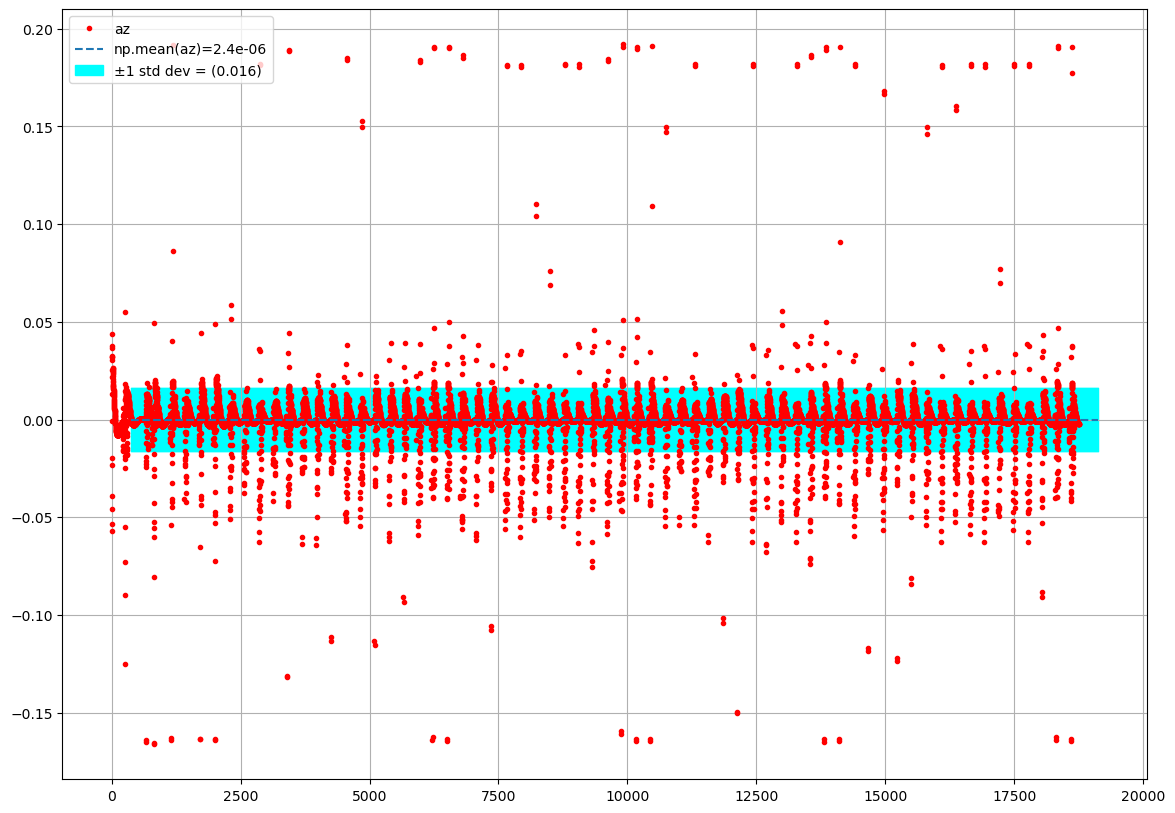

In [42]:
az_mean = np.mean(azc[start:])
az_std = np.std(azc[start:])

plt.plot(azc[start:], 'r.', label='az')
plt.hlines(az_mean, t2[0], t2[-1], ls='dashed', label=f'np.mean(az)={az_mean:.2}')
plt.fill_between(t2, az_mean - az_std, az_mean + az_std,  
                             color='cyan', alpha=1, 
                             label=f'±1 std dev = ({az_std:.2})')
plt.grid()
plt.legend()
plt.show()

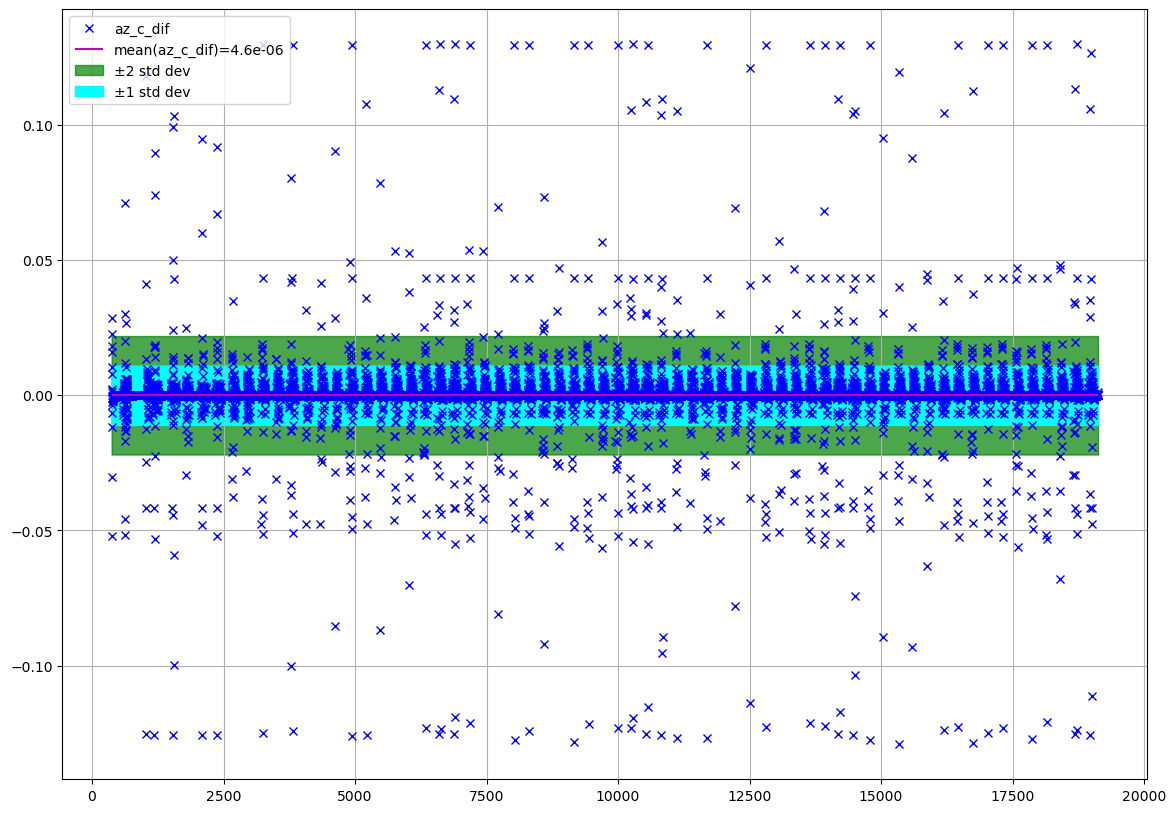

In [44]:
azc_dif_mean = np.mean(azc_dif[start:])
azc_dif_std = np.std(azc_dif[start:])

plt.plot(t2, azc_dif[start:], 'bx', label=f'az_c_dif')
plt.hlines(azc_dif_mean, t2[0], t2[-1], colors='m', label=f'mean(az_c_dif)={azc_dif_mean:.2}')
plt.fill_between(t2, azc_dif_mean - 2*azc_dif_std, azc_dif_mean + 2*azc_dif_std,  
                             color='green', alpha=0.7, 
                             label='±2 std dev')
plt.fill_between(t2, azc_dif_mean - azc_dif_std, azc_dif_mean + azc_dif_std,  
                             color='cyan', alpha=1, 
                             label='±1 std dev')

plt.grid()
plt.legend()
plt.show()

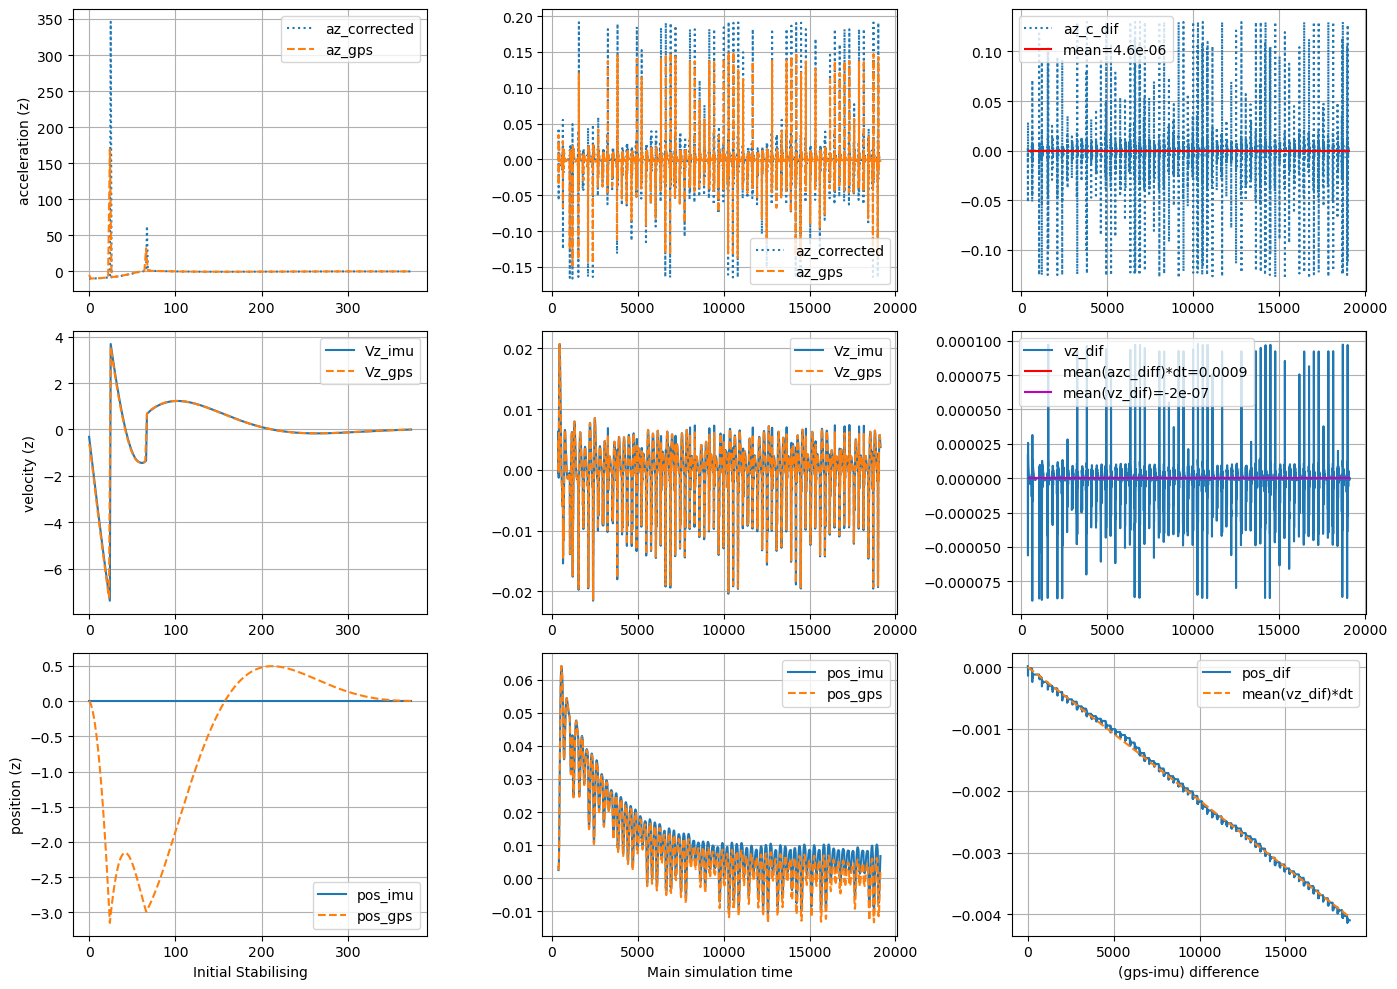

In [45]:
plt.subplot(3,3,1)
plt.ylabel('acceleration (z)')
#plt.plot(t1, az[:start], label='az_imu')
plt.plot(t1, azc[:start], ls=':', label='az_corrected')
plt.plot(t1, az_r[:start], ls='--', label='az_gps')
plt.legend()
plt.grid()
plt.subplot(3,3,2)
#plt.plot(t2, az[start:], label='az_imu')
plt.plot(t2, azc[start:], ls=':', label='az_corrected')
plt.plot(t2, az_r[start:], ls='--', label='az_gps')
plt.legend()
plt.grid()
plt.subplot(3,3,3)
#plt.plot(t2, az_dif[start:], label='az_dif')
plt.plot(t2, azc_dif[start:], ls=':', label='az_c_dif')
plt.hlines(np.mean(azc_dif[start:]), t2[0], t2[-1], colors='r', label=f'mean={np.mean(azc_dif[start:]):.2}')
#plt.hlines(-9.81, t2[0], t2[-1], colors='r', label='Gravity')
plt.legend()
plt.grid()

plt.subplot(3,3,4)
plt.ylabel('velocity (z)')
plt.plot(t1, vel[:start,2], label='Vz_imu')
plt.plot(t1, vel_zr[:start], ls='--', label='Vz_gps')
plt.legend()
plt.grid()
plt.subplot(3,3,5)
plt.plot(t2, vel[start:,2], label='Vz_imu')
plt.plot(t2, vel_zr[start:], ls='--', label='Vz_gps')
plt.legend()
plt.grid()
plt.subplot(3,3,6)
plt.plot(t2, vz_dif[start:], label='vz_dif')
plt.hlines(np.mean(azc_dif[start:])*dt/1000, t2[0], t2[-1], colors='r', label=f'mean(azc_diff)*dt={np.mean(azc_dif):.1}')
plt.hlines(np.mean(vz_dif[start:]), t2[0], t2[-1], colors='m', label=f'mean(vz_dif)={np.mean(vz_dif[start:]):.1}')
plt.legend()
plt.grid()

plt.subplot(3,3,7)
plt.ylabel('position (z)')
plt.plot(t1, pos_iz[:start], label='pos_imu')
plt.plot(t1, pos_r[:start,2], ls='--', label='pos_gps')
plt.legend()
plt.grid()
plt.xlabel('Initial Stabilising')

plt.subplot(3,3,8)
plt.plot(t2, pos_iz[start:], label='pos_imu')
plt.plot(t2, pos_r[start:,2], ls='--', label='pos_gps')
plt.legend()
plt.grid()
plt.xlabel('Main simulation time')

plt.subplot(3,3,9)
plt.plot(pos_dif[start:], label='pos_dif')
time = np.arange(len(pos_dif[start:]))
plt.plot(np.mean(vz_dif[start:])*time, ls='--', label='mean(vz_dif)*dt')
plt.legend()
plt.grid()
plt.xlabel('(gps-imu) difference')

plt.tight_layout()
plt.show()
plt.savefig('positionalComparison.png')
plt.close()

Simulation data
 Using gains:[0.2 0.4 0.6 0.8 1. ]


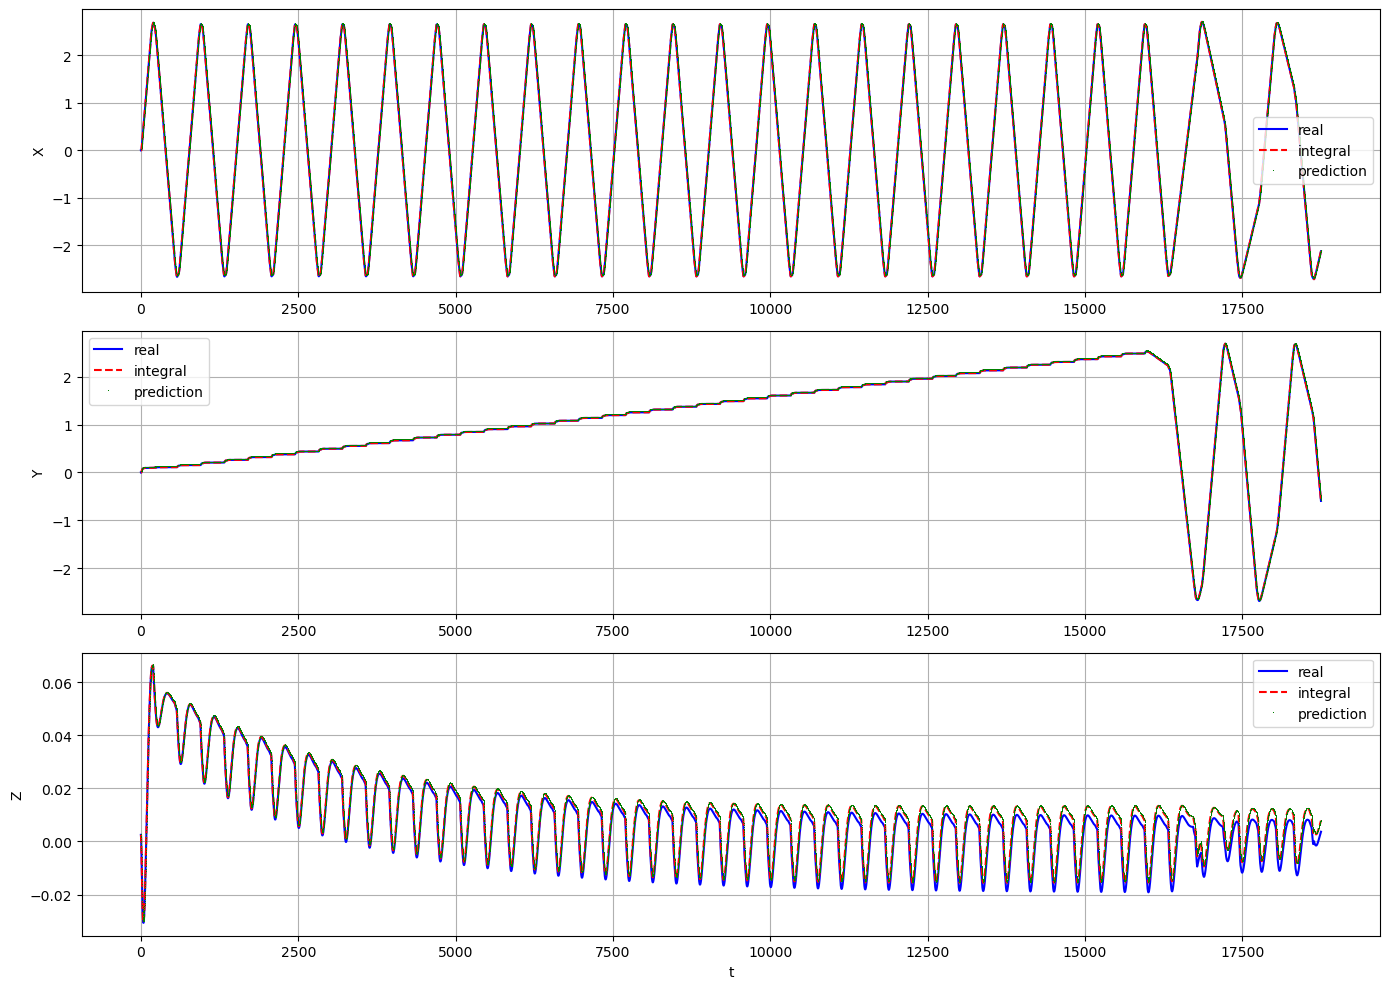

In [32]:
print(f'Simulation data\n Using gains:{gains}')
XYZoverTime(pos_r[start:], pos_i, pos_i)
#plot_rolling_timeseries_stats(pos_i, pos_p, window_size=100)

In [56]:
pred_error = (pos_i - pos_p)**2
rolling_mean = np.zeros_like(pred_error[:,0])
rolling_std = np.zeros_like(pred_error[:,0])

window_size = 100
for j in range(len(pred_error)):
    # Determine the window boundaries
    start = max(0, j - window_size // 2)
    end = min(len(pred_error), j + window_size // 2)
    
    # Calculate local statistics
    window_data = pred_error[start:end]
    rolling_mean[j] = np.mean(window_data)
    rolling_std[j] = np.std(window_data)

NameError: name 'pos_p' is not defined

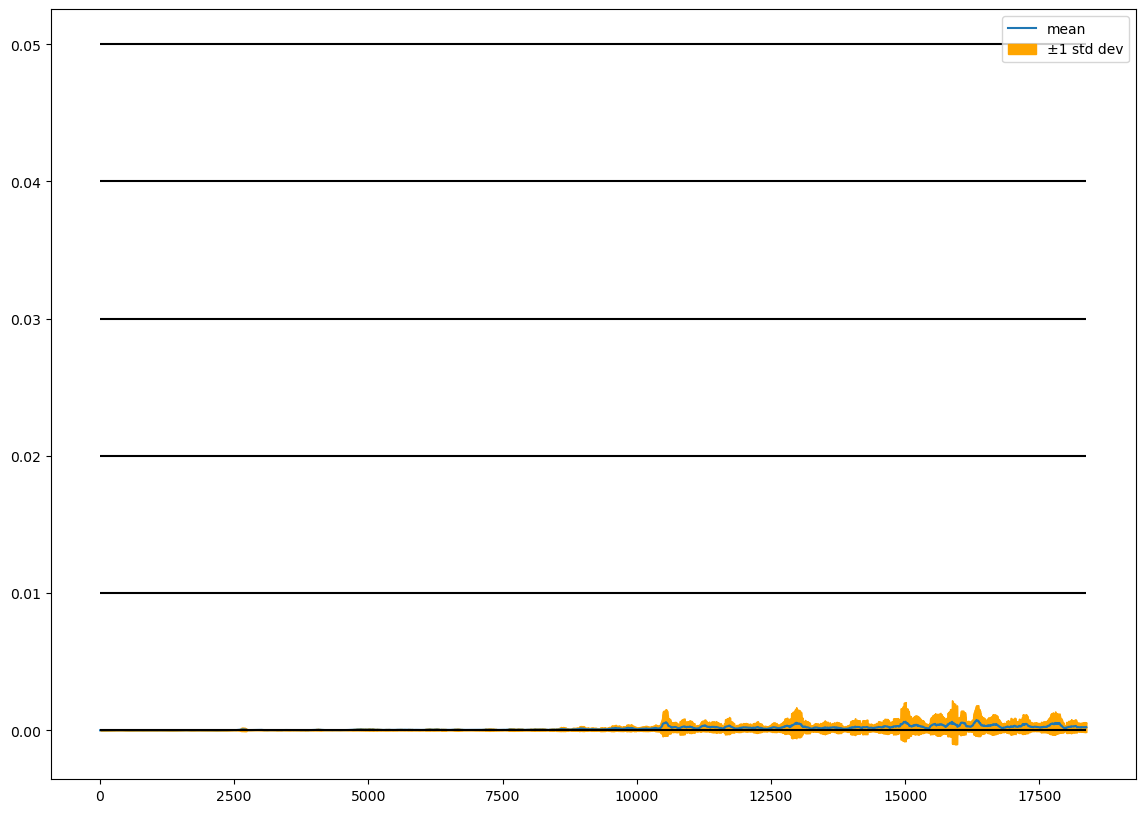

In [51]:
plt.plot(rolling_mean, label='mean')
plt.fill_between(range(len(pred_error)), rolling_mean - rolling_std, rolling_mean + rolling_std, color='orange', label='±1 std dev')
#plt.plot(rolling_std, label='std')
plt.hlines([0, 0.01, 0.02, 0.03, 0.04, 0.05], 0, len(pred_error), color='k')
plt.legend()
plt.show()

# Neural Activity

Projection in ['X' 'Y']
Projection in ['Y' 'Z']


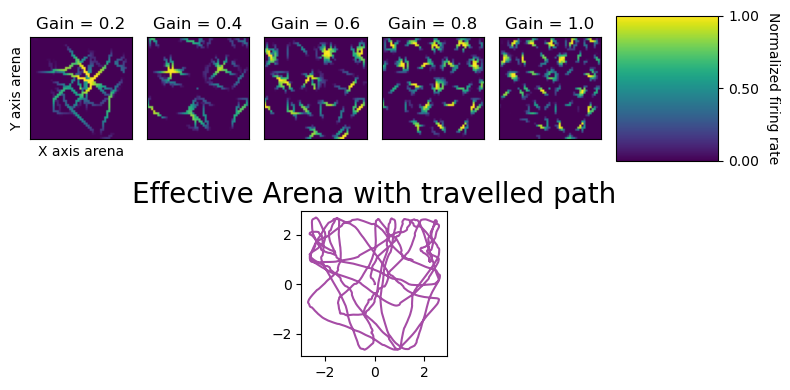

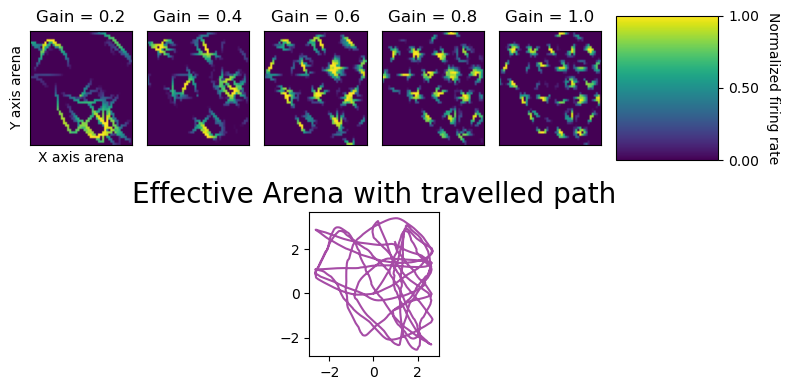

In [52]:
plot_modular_activity(projection_operator, pos_i, activity, gains, ID, projection)

# Analysis for Benchmarking techniques and training time

Files are:
- BenchmarkingShort
- BenchmarkingLine
- Benchmarking2
- Benchmarking
- BenchmarkingLong
- Benchmarking1D (perfect predictions)
- Benchmarking2D (only z prediction bad)
- Benchmarking3D
- BenchmarkingVel
- BenchmarkingVelLong

In [107]:
name = f'BenchmarkTime setting{len(time)}/{len(time)}'
i = 10
filename = f'Results\\ID {name}\\Data trial{i}.pickle'
data = load_object(filename)

In [102]:
name = 'Benchmarking1DVel' #'MovementCheck3D'
filename = f'Results\\ID {name}\\Data {name}.pickle'
#data = load_object(filename)

ID = data['name'] # name of the simulation
boundaries = data['boundaries']
minutes = data['sim time']
dt = data['dt ms'] # in ms
gains = np.array(data['gains']) # list of gains that every network uses
projection = np.array(data['modular projections']) # bool of the dim each module projects
projection_operator = np.array(data['module operators']) # operator used to project 3d data to modules
noise = data['noise']
vel = np.array(data['velocity'])
activity = np.array(data['activity']) # neural network activity 
pos_r = np.array(data['position']) # real position
pos_i = np.array(data['position internal']) # integrator position
training_end_index = data['training time index']

pos_p_on = np.array(data['online prediction']) # predicted position
mse_on = np.array(data['online mse']) # mse online

pos_p_on_short = np.array(data['online short prediction']) # predicted position
mse_on_short = np.array(data['online short mse']) # mse online

pos_p_off = data['offline prediction']
mse_off = data['mse'] # scalar mse mean offline
mse_off_sh = data['mse_shuffeled'] # scalar mse shuffeled offline
r2_off = data['r2_mean'] # scalar r2 score offline
r2_off_sh = data['r2_shuffeled'] # scalar r2 shuffeled offline

pos_p_off_short = data['offline short prediction']
mse_off_short = data['mse short'] # scalar mse mean offline
mse_off_sh_short = data['mse shuffeled short'] # scalar mse shuffeled offline
r2_off_short = data['r2 mean short'] # scalar r2 score offline
r2_off_sh_short = data['r2 shuffeled short'] # scalar r2 shuffeled offline

start = len(pos_r) - len(pos_i)
t1 = np.arange(0, start)
t2 = np.arange(start, len(pos_r))

In [103]:
print(f''' Simulation was run with ---
Name : {ID}
Minutes simulated : {minutes}
Gains used by 2d modules: {gains}
Amount of modules used : {len(projection)}
Projection of the modules by module and dimension : \n{projection}
Timestep dt of the simulation in ms : {dt}
Last training step : {training_end_index}''')

print(f"gains shape: {gains.shape}")
print(f"projection_operator shape: {projection_operator.shape}")
print(f"activity shape: {activity.shape}")
print(f"pos_r shape: {pos_r.shape}")

 Simulation was run with ---
Name : trial10
Minutes simulated : 10.0
Gains used by 2d modules: [0.2 0.5 0.7 1. ]
Amount of modules used : 3
Projection of the modules by module and dimension : 
[[ True  True False]
 [False  True  True]
 [ True False  True]]
Timestep dt of the simulation in ms : 32
Last training step : 15674
gains shape: (4,)
projection_operator shape: (3, 2, 3)
activity shape: (18751, 3, 4, 90)
pos_r shape: (19125, 3)


In [104]:
print(f'MSE results\n online: {np.mean(mse_on)}\n online test: {np.mean(mse_on_short)}\n offline: {mse_off} \n offline test: {mse_off}') 

MSE results
 online: 0.0004454757184202568
 online test: 0.0022007322405673906
 offline: 0.00023 
 offline test: 0.00023


Smallest mse:
- 0.027 | online full BenchmarkingVel (decode pos+velocity, 6min)
- 0.045 | online full BenchmarkingVelLong (decode pos+velocity, 60min)
- 0.043 | online full Benchmarking3D (30min)
- 0.00058 | online full Benchmarking2D (10min, near zero in z)
- 0.0085  | online **Test** Benchmarking2DVel (10min, ang std=0.0, start=[1,1,0]) (max both offline 0.020)
- 0.0087 | online **test** Benchmarking1D (10min, very simple movement, worst decoder has 0.0207 -> both offline versions)
- 0.205 | **offline both**  Benchmarking1DVel (10min, ang std=0.0, start=[1,0,0]) (max 184.97 online test)
- 0.049 | online full BenchmarkingRandomVel (30min, angular std = 0.25) (max was online test with 5.59)
- 0.036 | online full BenchmarkingRandomVelShort (10min, angular std=0.25) (max online test = 6.26)
- 0.037 | online full BenchmarkingRandomShort (10min, angular std=0.25) (max online test = 4.02)
- 0.052 | online full BenchmarkingRandom (30min, angular std=0.25) (max online test = 5.40)

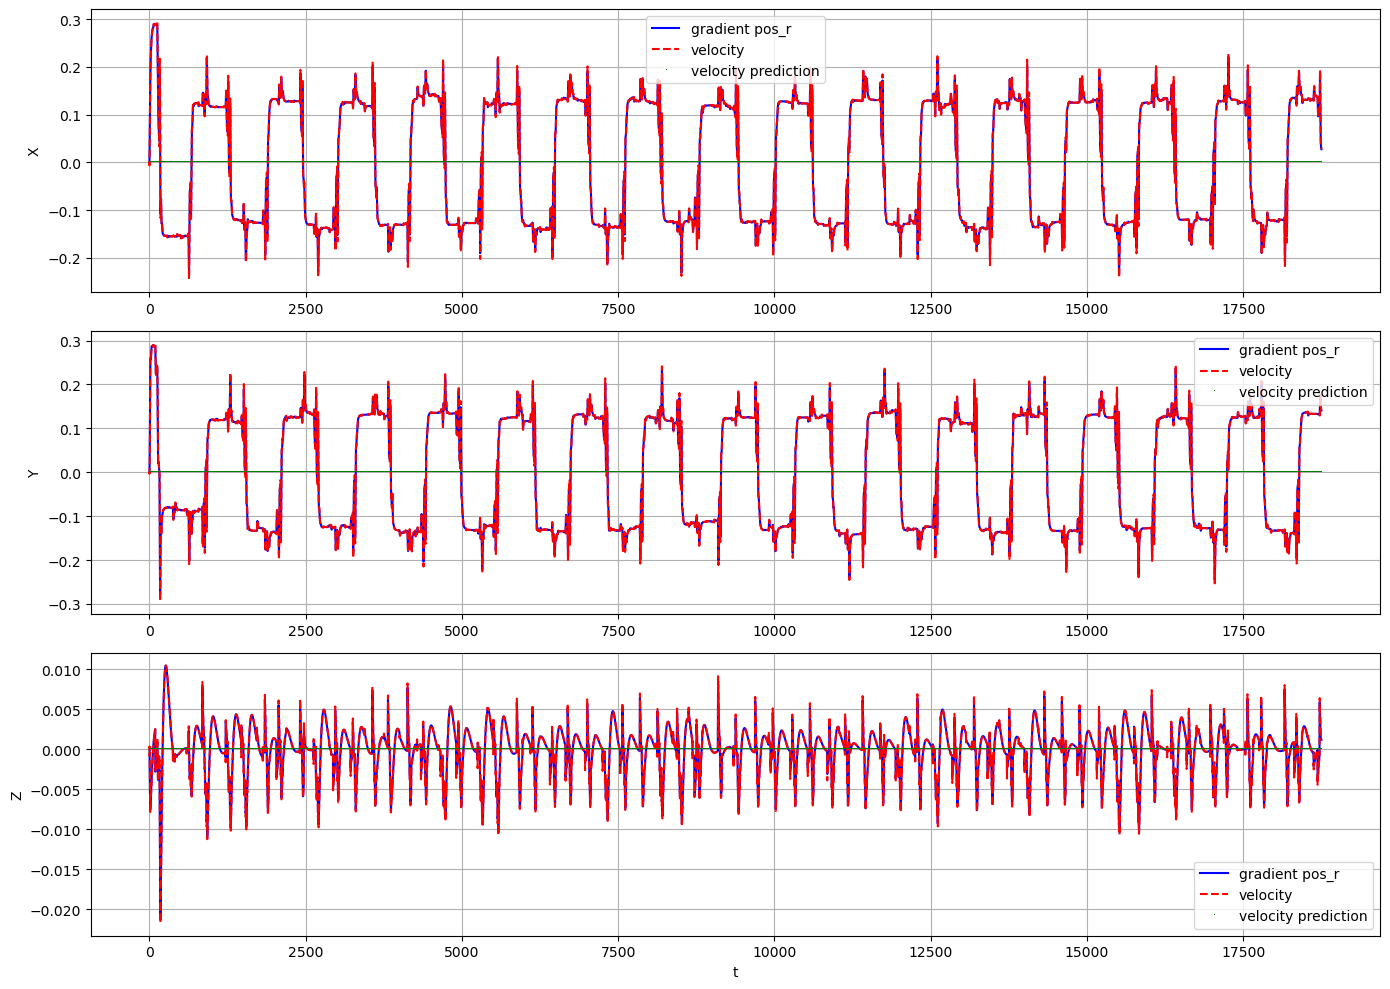

In [105]:
vel_on = np.array(data['online vel prediction'])
XYZoverTime(np.gradient(pos_r[start:], dt/1000, axis=0), vel[start:], vel_on,  [ 'gradient pos_r', 'velocity', 'velocity prediction'])

Online full


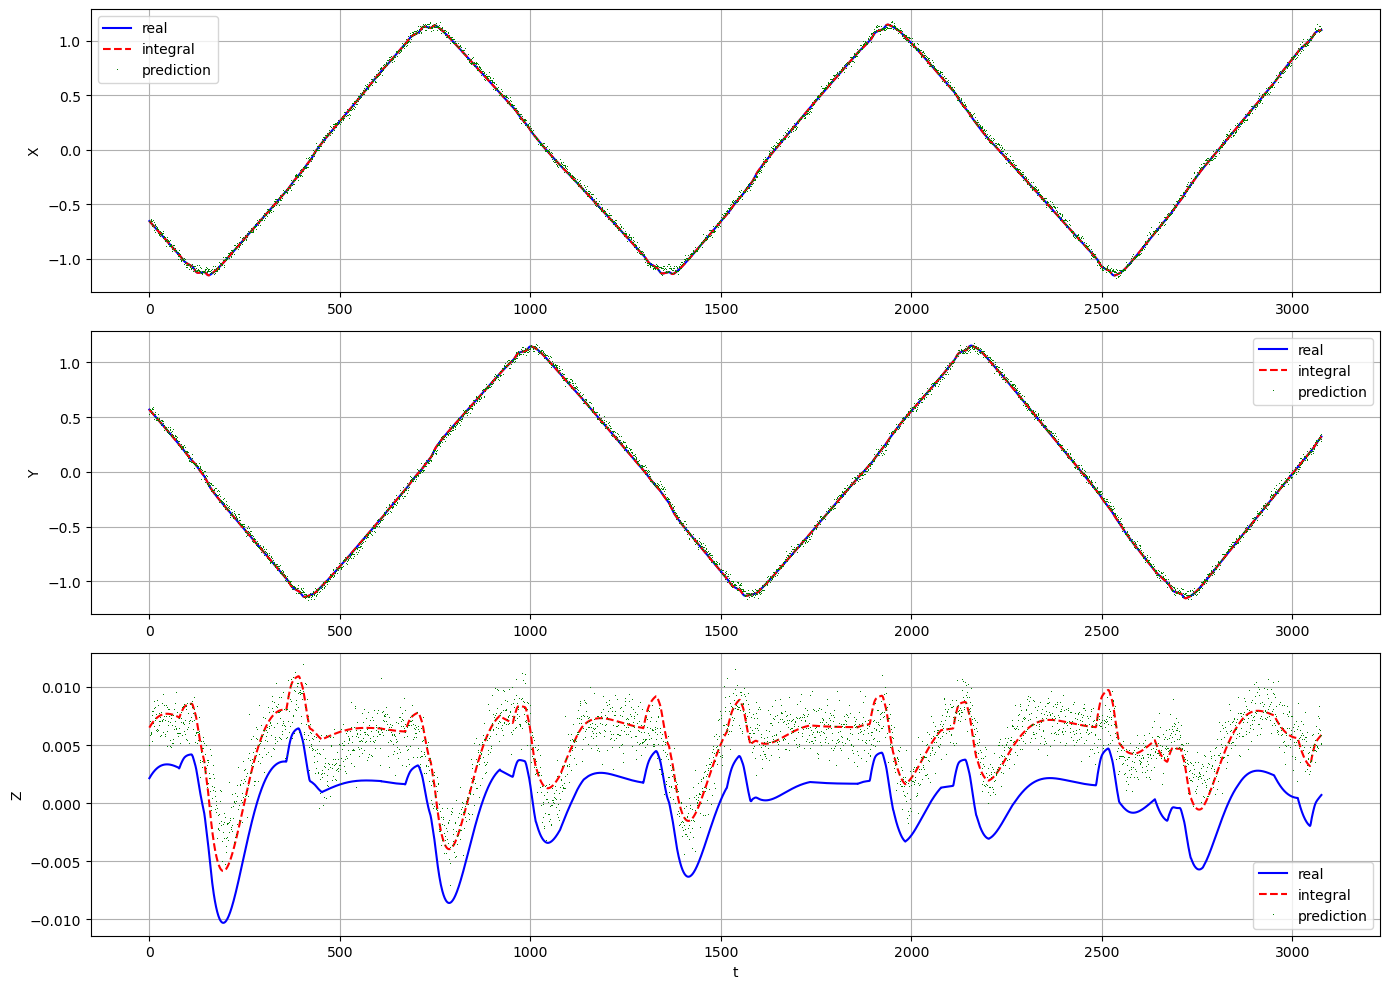

Online short


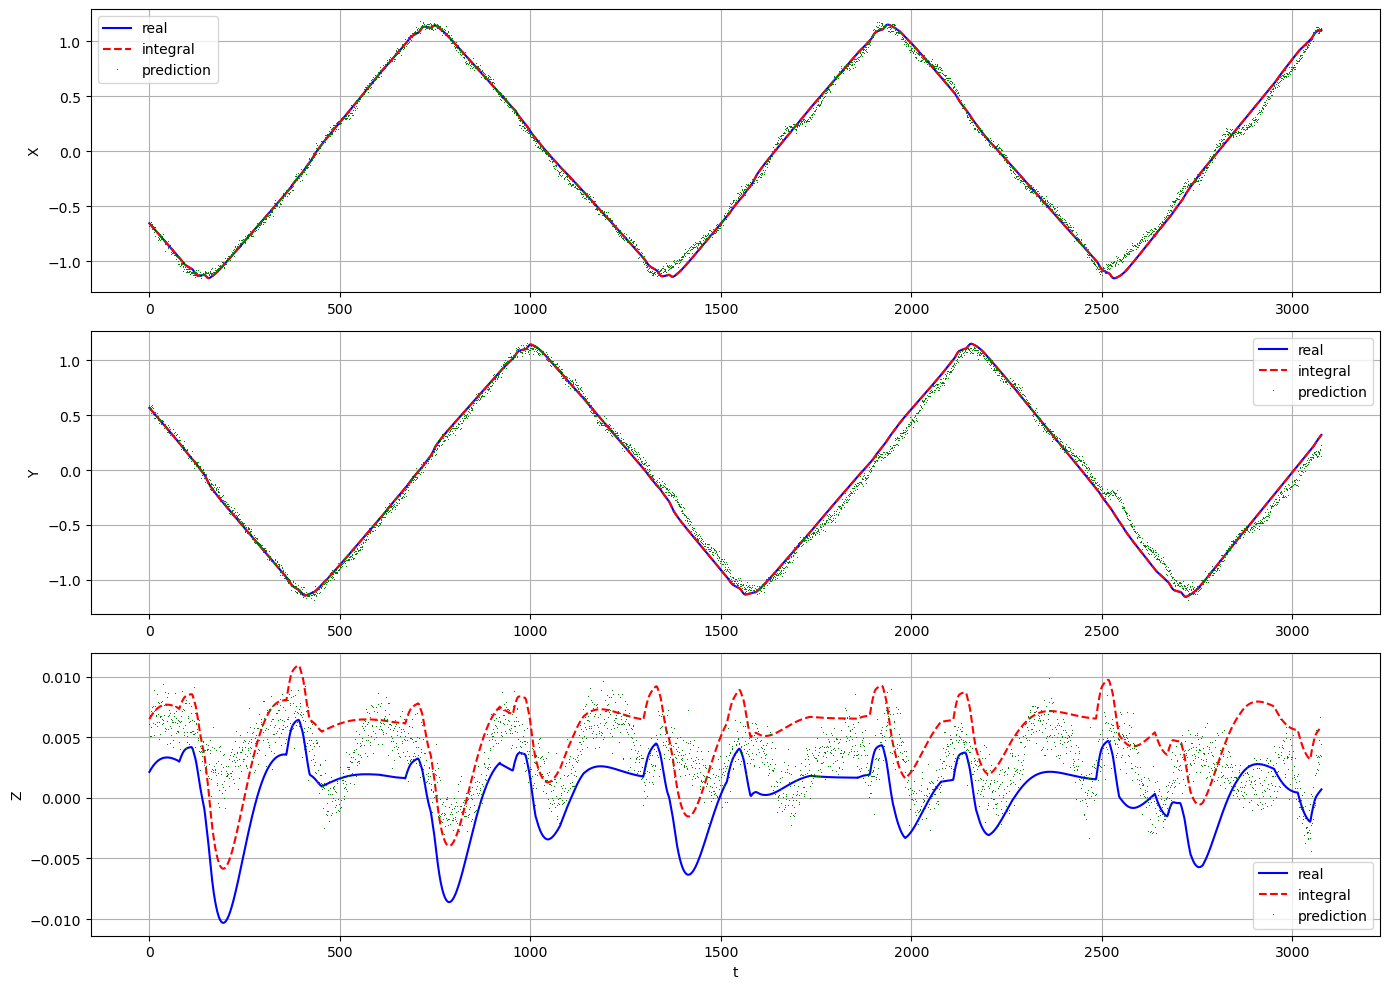

Offline full


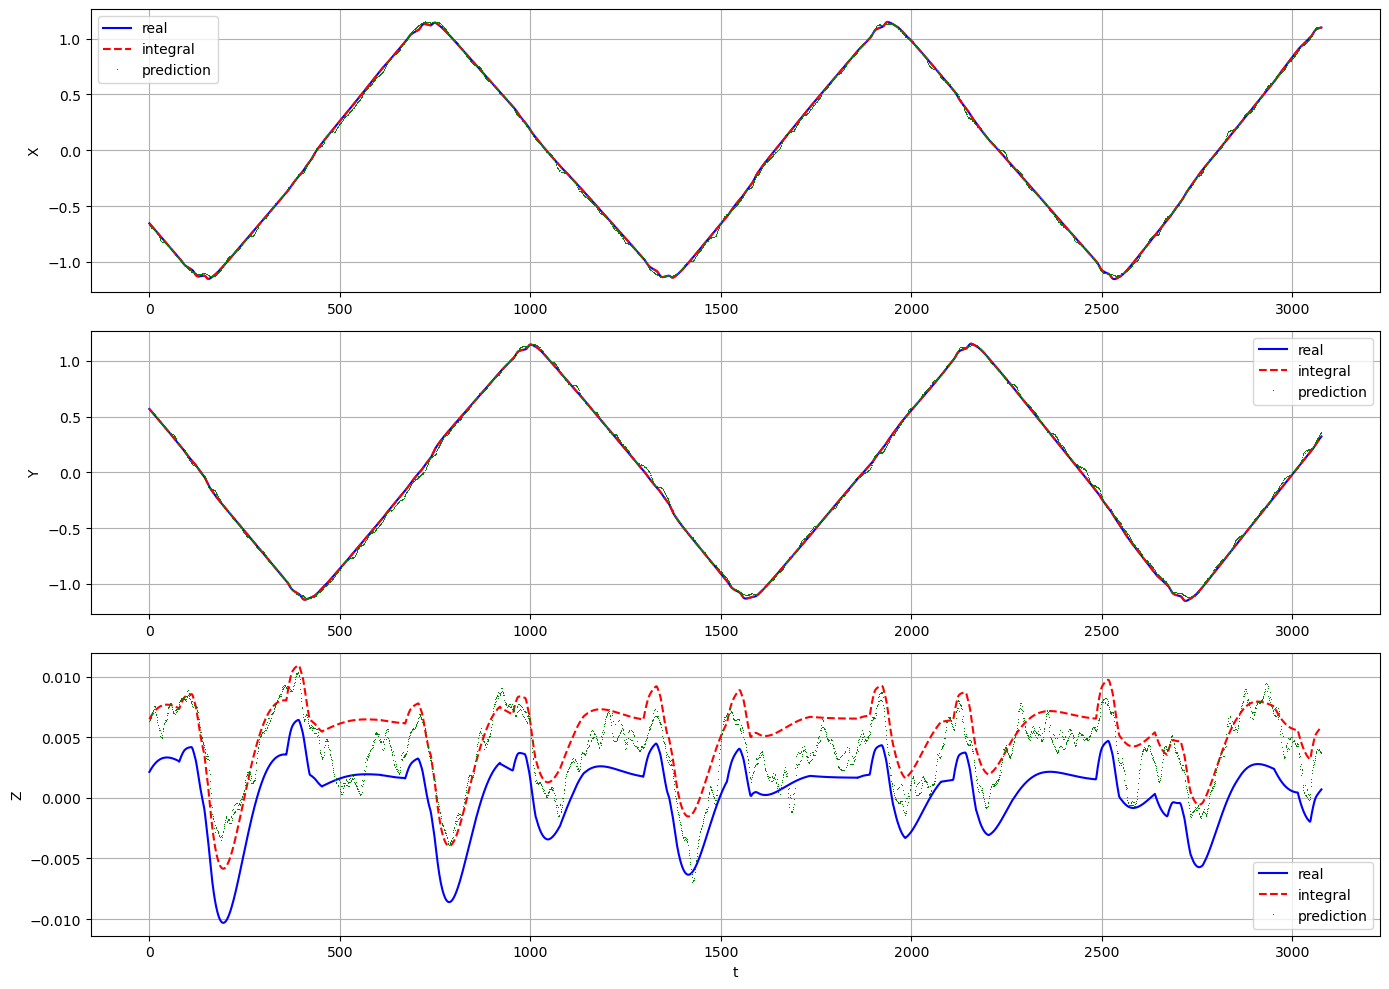

Offline short


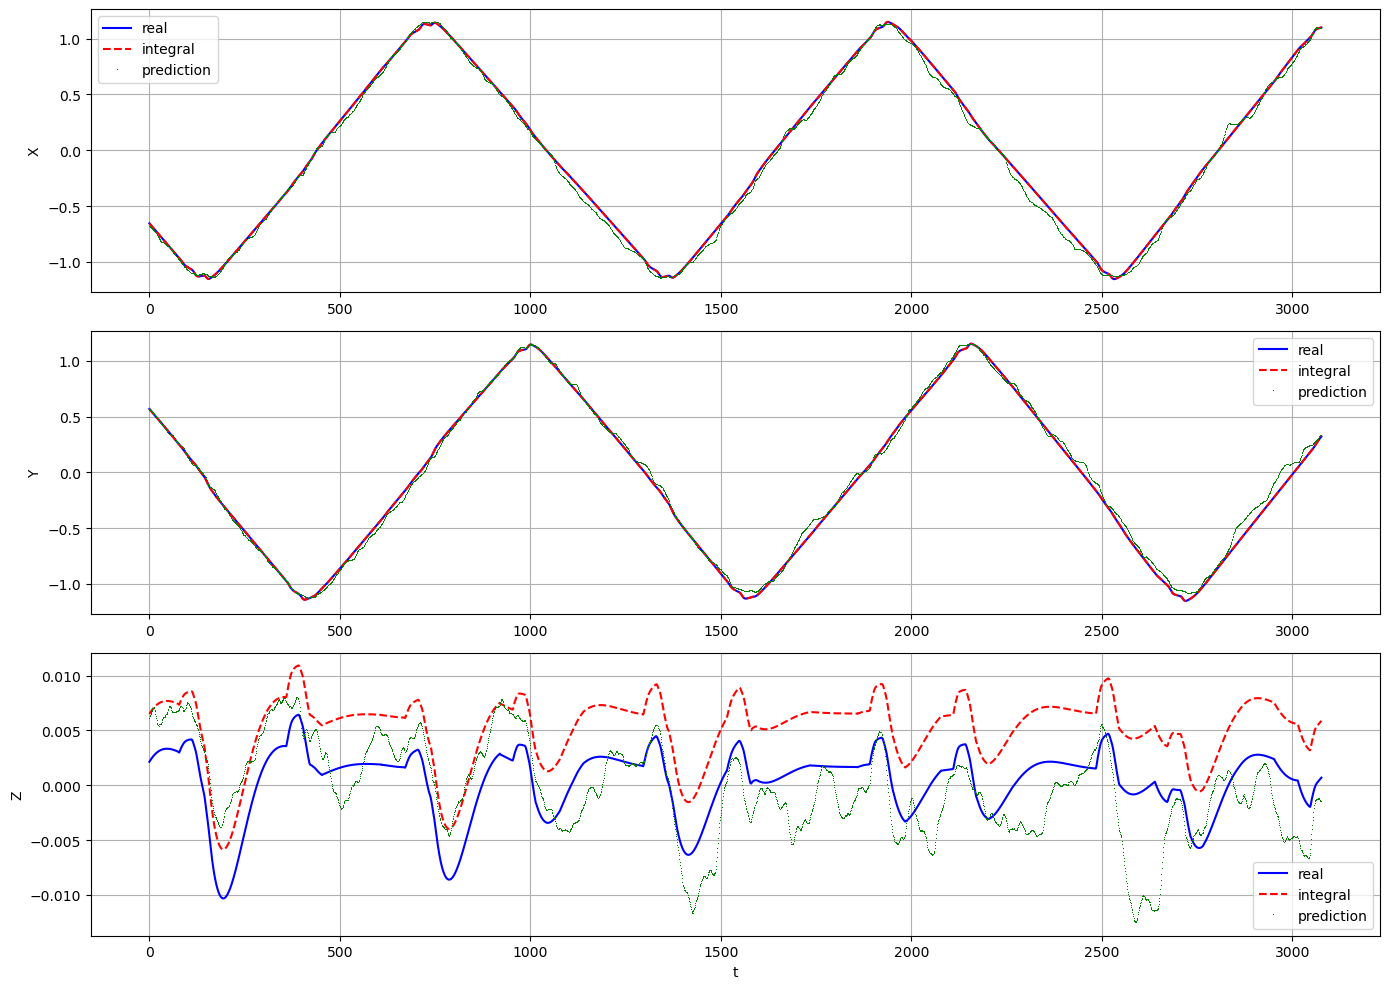

In [108]:
aux_r, aux_i, = pos_r[start+training_end_index:], pos_i[training_end_index:]
aux_pon = pos_p_on[training_end_index:]
aux_pof = pos_p_off[training_end_index:]
print('Online full')
XYZoverTime(aux_r, aux_i, aux_pon) #XYZoverTime(pos_r[start:], pos_i, pos_p_on)
print('Online short')
XYZoverTime(aux_r, aux_i, pos_p_on_short[start:]) #XYZoverTime(pos_r[start:], pos_i, pad_to_length(pos_p_on_short, pos_i.shape[0]))
print('Offline full')
XYZoverTime(aux_r, aux_i, aux_pof) #XYZoverTime(pos_r[start:], pos_i, pos_p_off)
print('Offline short')
XYZoverTime(aux_r, aux_i, pos_p_off_short) #XYZoverTime(pos_r[start:], pos_i, pad_to_length(pos_p_off_short, pos_i.shape[0]))

In [141]:
convergence = data['rls convergence matrix']

weight_changes = np.array(convergence['weight_changes'])
weight_norms = np.array(convergence['weight_norms'])
prediction_errors = np.array(convergence['prediction_errors'])
gain_norms = np.array(convergence['gain_norms'])
innovation_norms = np.array(convergence['innovation_norms'])

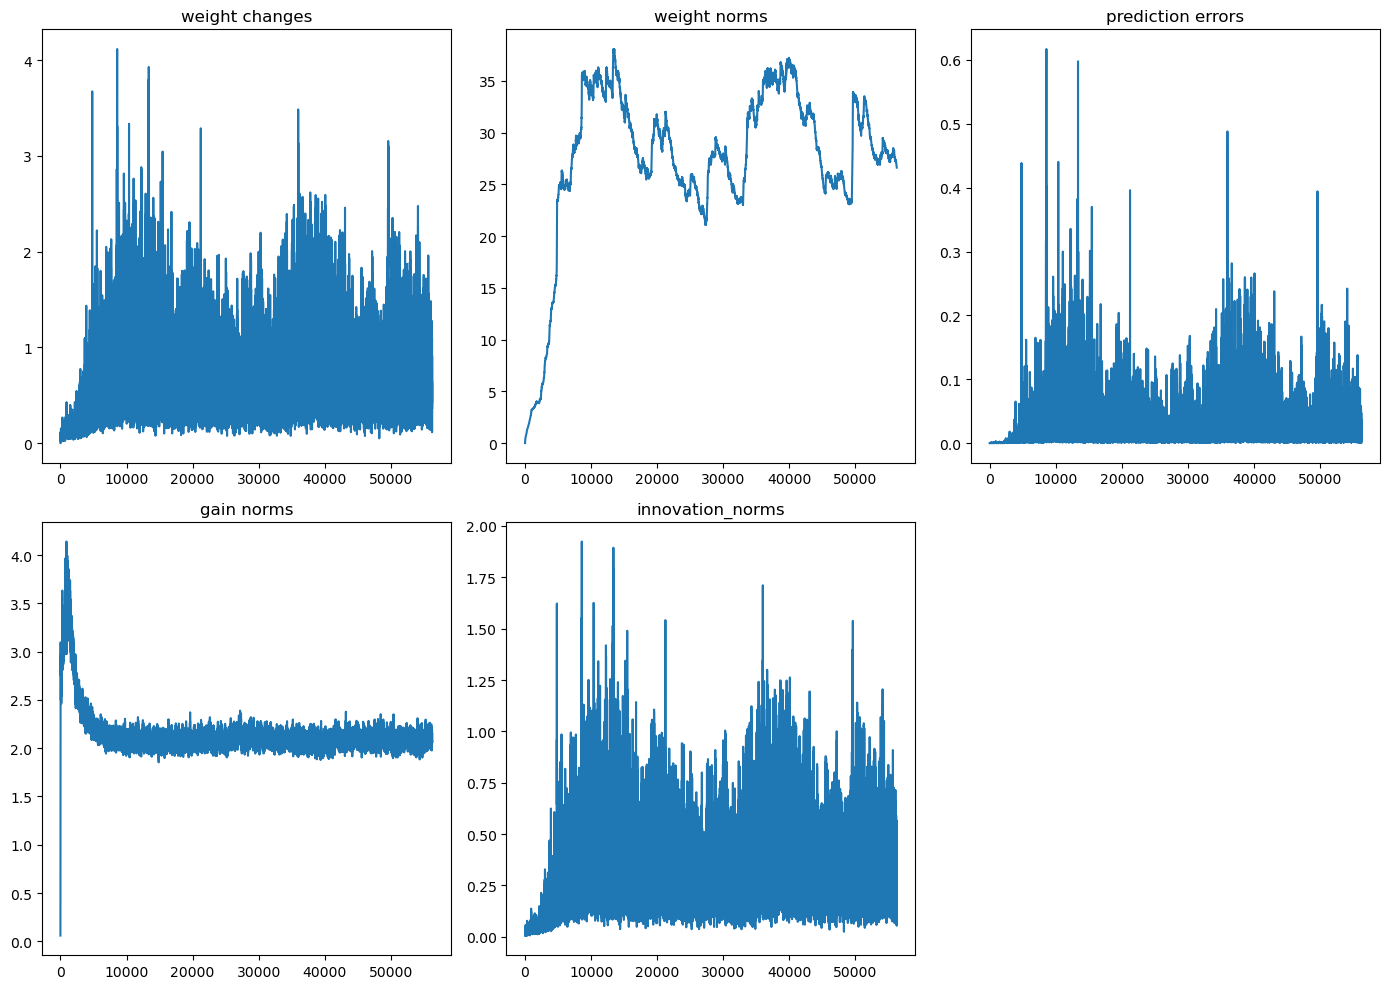

In [142]:
plt.subplot(2,3,1)
plt.plot(weight_changes)
plt.title('weight changes')
plt.subplot(2,3,2)
plt.plot(weight_norms)
plt.title('weight norms')
plt.subplot(2,3,3)
plt.plot(prediction_errors)
plt.title('prediction errors')
plt.subplot(2,3,4)
plt.plot(gain_norms)
plt.title('gain norms')
plt.subplot(2,3,5)
plt.plot(innovation_norms)
plt.title('innovation_norms')
plt.tight_layout()
plt.show()

# Analysis of multitrial benchmarks

In [42]:
time = [5.0, 7.5, 10.0, 15.0, 20.0, 30.0]
mse_on = np.zeros(len(time))
std_on = np.zeros(len(time))
mse_onSh = np.zeros(len(time))
std_onSh = np.zeros(len(time))
mse_of = np.zeros(len(time))
std_of = np.zeros(len(time))
mse_ofSh = np.zeros(len(time))
std_ofSh = np.zeros(len(time))
cov = np.zeros(len(time))
cov_std = np.zeros(len(time))
cov_test = np.zeros(len(time))
cov_std_test = np.zeros(len(time))

for i in range(len(time)):
    name = f'BenchmarkTime setting{i+1}of{len(time)}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    mse_on[i] = data['avg online mse']
    std_on[i] = data['std online mse']
    mse_onSh[i] = data['avg online short mse']
    std_onSh[i] = data['std online short mse']
    mse_of[i] = data['avg offline mse']
    std_of[i] = data['std offline mse']
    mse_ofSh[i] = data['avg offline mse short']
    std_ofSh[i] = data['std offline mse short']
    cov[i] = data['avg coverage']
    cov_std[i] = data['std coverage']
    cov_test[i] = data['avg coverage train']
    cov_std_test[i] = data['std coverage train']

    #print(f'{name} time = {time[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')

In [36]:
plt.rcParams["figure.figsize"] = (14,10)

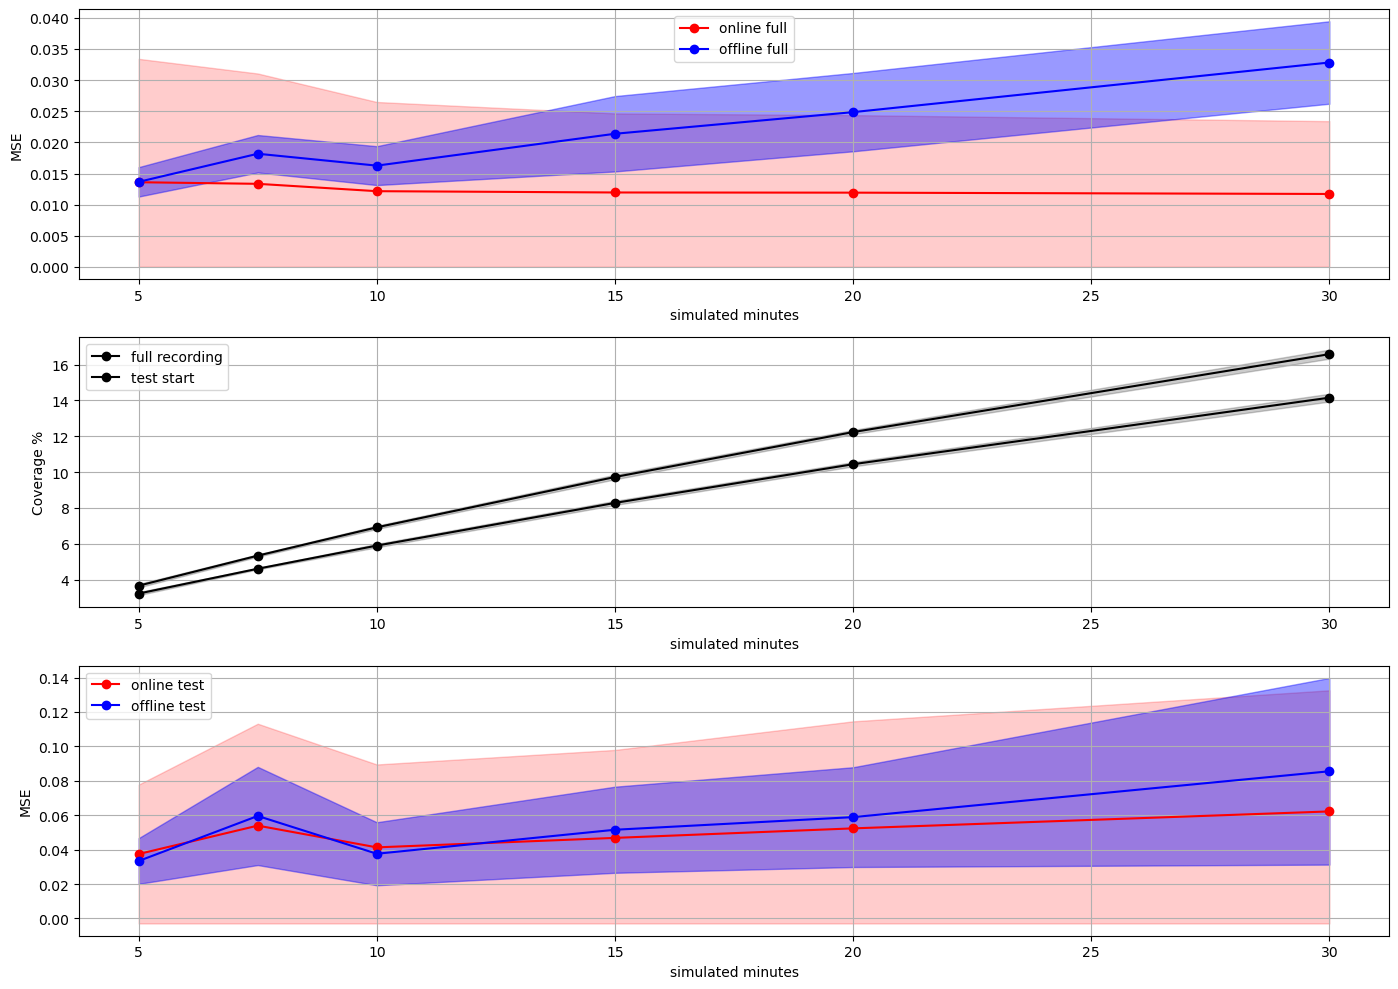

In [43]:
plt.subplot(3,1,1)
plt.plot(time, mse_on, 'r-o', label='online full')
plt.fill_between(time, np.max(mse_on - std_on, 0), mse_on + std_on, color='red', alpha=0.2)
plt.plot(time, mse_of, 'b-o', label='offline full')
plt.fill_between(time, mse_of - std_of , mse_of + std_of, color='blue', alpha=0.4)
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('simulated minutes')
#plt.ylim((0, 0.0015))
plt.subplot(3,1,2)
plt.plot(time, cov, 'k-o', label='full recording')
plt.fill_between(time, cov - cov_std, cov + cov_std, color='k', alpha=0.2)
plt.plot(time, cov_test, 'k-o', label='test start')
plt.fill_between(time, cov_test - cov_std_test, cov_test + cov_std_test, color='k', alpha=0.2)
plt.grid()
plt.legend()
plt.xlabel('simulated minutes')
plt.ylabel('Coverage %')
plt.subplot(3,1,3)
plt.plot(time, mse_onSh,'r-o', label='online test')
plt.fill_between(time, np.max(mse_onSh - std_onSh, 0), mse_onSh + std_onSh, color='red', alpha=0.2)
plt.plot(time, mse_ofSh, 'b-o', label='offline test')
plt.fill_between(time, mse_ofSh - std_ofSh, mse_ofSh + std_ofSh, color='blue', alpha=0.4)
#plt.ylim((0, 0.05))
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('simulated minutes')
plt.tight_layout()
plt.show()

In [45]:
noise = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.99]
mse_on = np.zeros(len(noise))
std_on = np.zeros(len(noise))
mse_onSh = np.zeros(len(noise))
std_onSh = np.zeros(len(noise))
mse_of = np.zeros(len(noise))
std_of = np.zeros(len(noise))
mse_ofSh = np.zeros(len(noise))
std_ofSh = np.zeros(len(noise))

for i in range(len(noise)):
    name = f'BenchmarkNoise setting{i+1}of{len(noise)}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    mse_on[i] = data['avg online mse']
    std_on[i] = data['std online mse']
    mse_onSh[i] = data['avg online short mse']
    std_onSh[i] = data['std online short mse']
    mse_of[i] = data['avg offline mse']
    std_of[i] = data['std offline mse']
    mse_ofSh[i] = data['avg offline mse short']
    std_ofSh[i] = data['std offline mse short']
    

    #print(f'{name} noise = {noise[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')

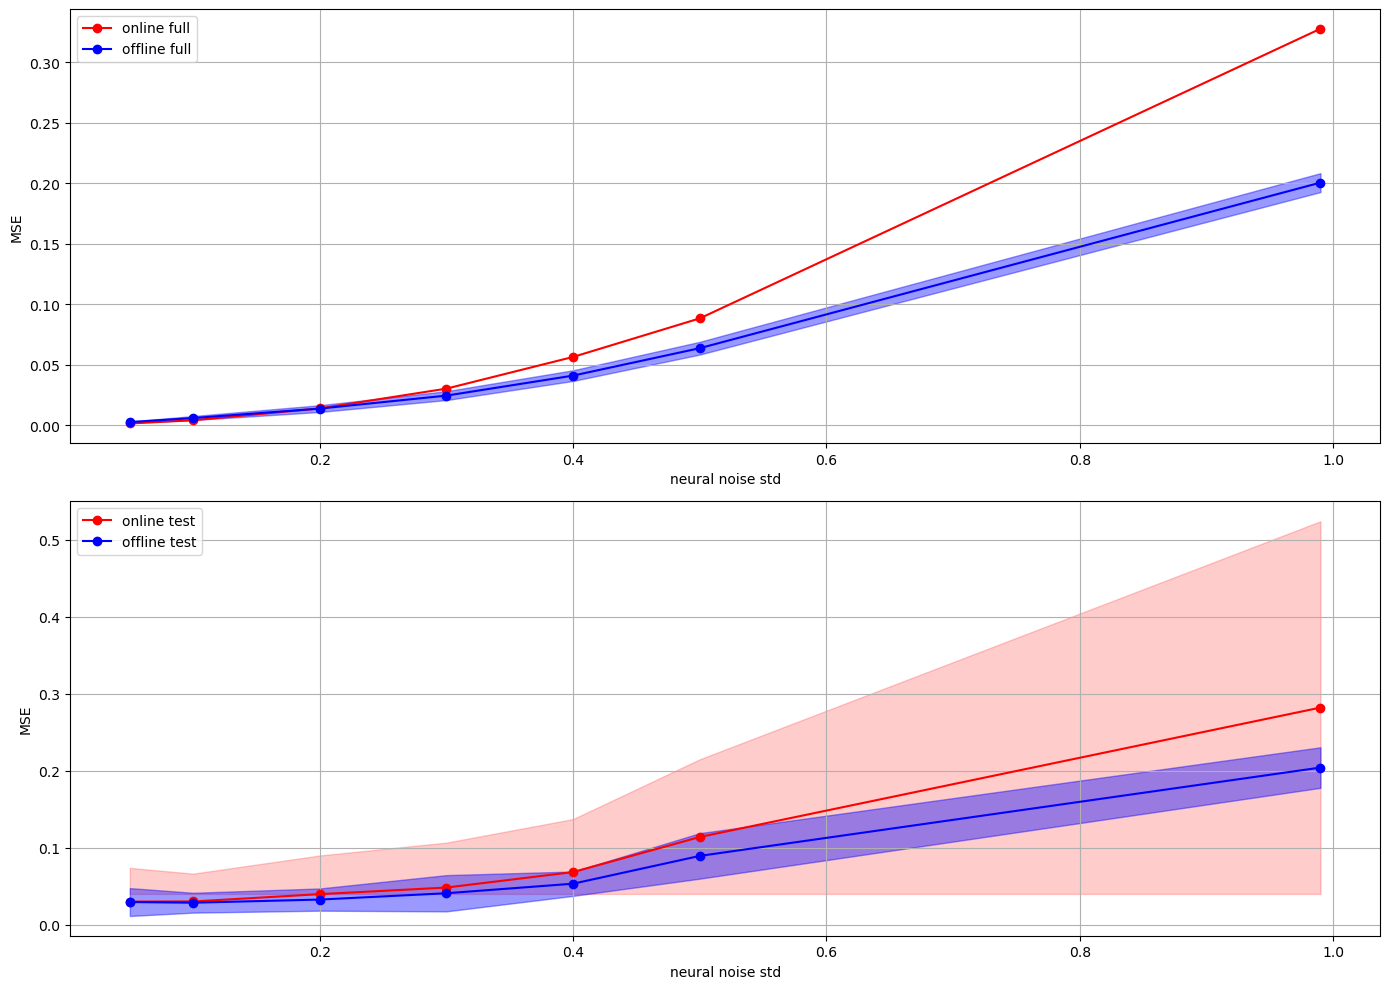

In [47]:
plt.subplot(2,1,1)
plt.plot(noise, mse_on, 'r-o', label='online full')
#plt.fill_between(noise, np.max(mse_on - std_on, 0), mse_on + std_on, color='red', alpha=0.2)
plt.plot(noise, mse_of, 'b-o', label='offline full')
plt.fill_between(noise, mse_of - std_of, mse_of + std_of, color='blue', alpha=0.4)
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('neural noise std')
#plt.ylim((0, 0.2))
plt.subplot(2,1,2)
plt.plot(noise, mse_onSh, 'r-o', label='online test')
plt.fill_between(noise, np.max(mse_onSh - std_onSh, 0), mse_onSh + std_onSh, color='red', alpha=0.2)
plt.plot(noise, mse_ofSh, 'b-o', label='offline test')
plt.fill_between(noise, mse_ofSh - std_ofSh, mse_ofSh + std_ofSh, color='blue', alpha=0.4)
#plt.ylim((0, 0.04))
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('neural noise std')
plt.tight_layout()
plt.show()

## Estimate Volume Coverage

In [10]:
visited_space_all = []
bounds = boundaries.flatten()
name = f'BenchmarkTime setting{len(time)}/{len(time)}'
for i in tqdm(range(20)):
    filename = f'Results\\ID {name}\\Data trial{i}.pickle'
    data = load_object(filename)
    pos_i = data['position internal']
    visited_space_all.append(estimate_visited_space_percentage(pos_r, bounds, voxel_size=0.05))

NameError: name 'boundaries' is not defined

In [11]:
coverage_avg = []
coverage_std = []
for i in range(len(noise)):
    name = f'BenchmarkNoise setting{i+1}of{len(noise)}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
    coverage_avg.append(data['avg coverage train'])
    coverage_std.append(data['std coverage train'])

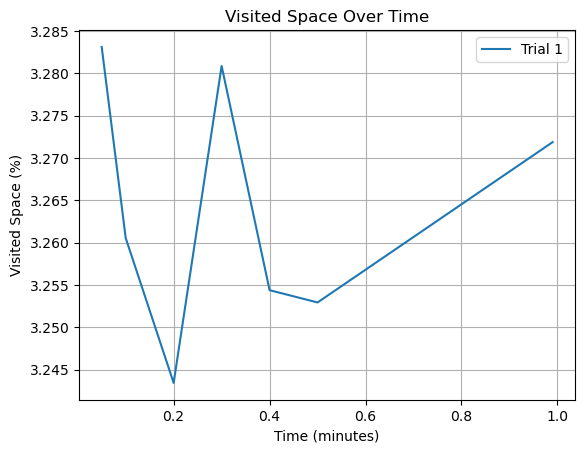

In [30]:
coverage_avg = np.array(coverage_avg)
x_time = np.array(range(len(coverage_avg))) / 32 /60
x_noise = noise

plt.plot(x_noise, coverage_avg, label=f'Trial {i+1}')
plt.xlabel('Time (minutes)')
plt.ylabel('Visited Space (%)')
plt.title('Visited Space Over Time')
plt.grid()
plt.legend()
plt.show()

# Plot the results

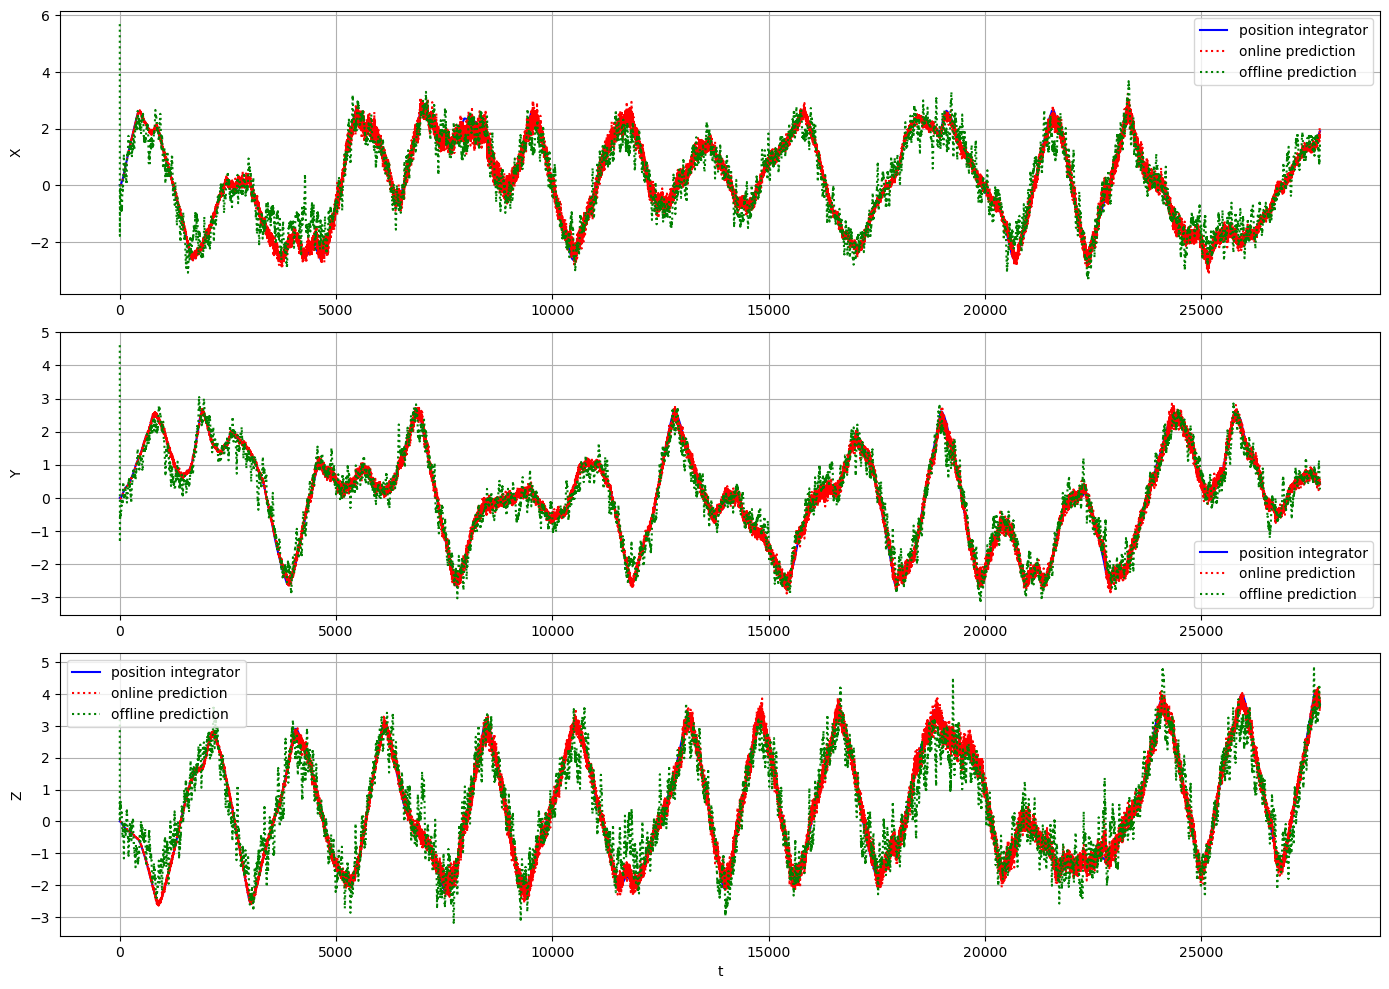

In [20]:
XYZoverTime(pos_i, pos_p, y_pred, [ 'position integrator', 'online prediction', 'offline prediction'], ['b-', 'r:', 'g:'])

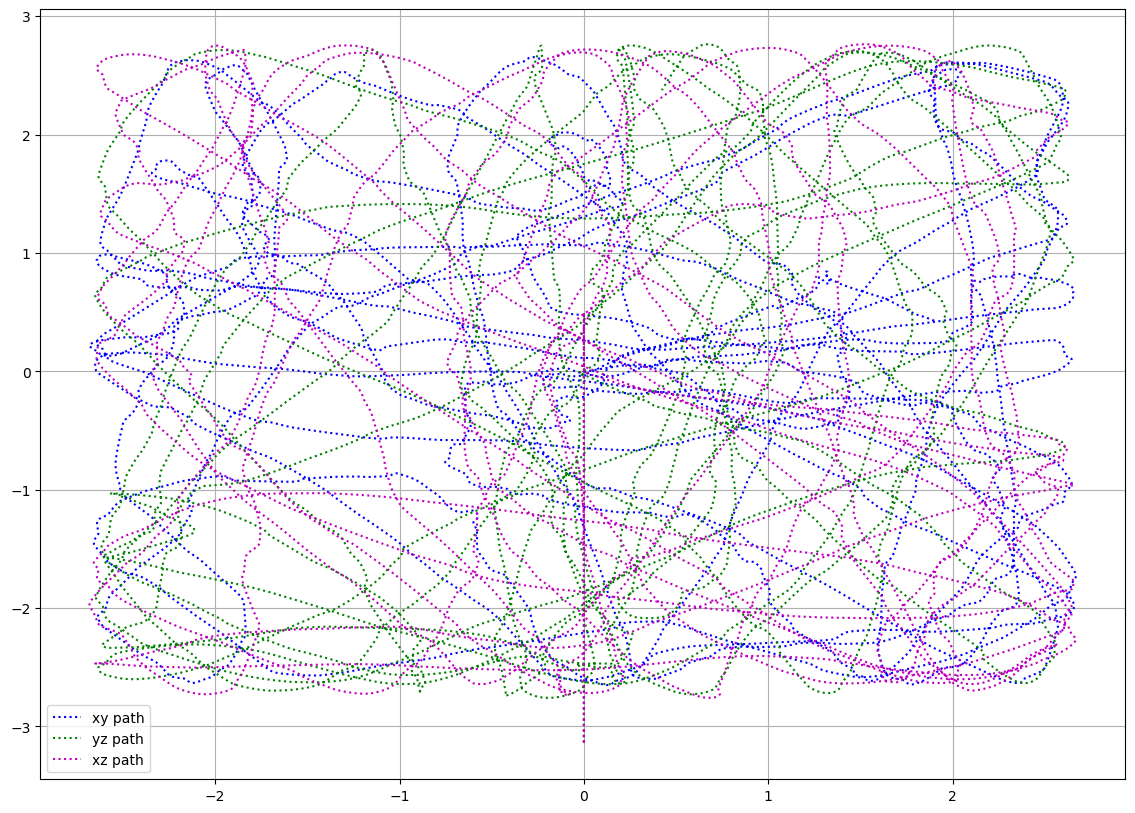

In [54]:
x, y, z = pos_r[:,0], pos_r[:,1], pos_r[:,2]
plt.plot(x, y, 'b:', label='xy path')
plt.plot(y, z, 'g:', label='yz path')
plt.plot(x, z, 'm:', label='xz path')
plt.grid()
plt.legend()
plt.show()

In [18]:
plot_3d_trajectory(pos_r, boundaries, ID=ID)

NameError: name 'plot_3d_trajectory' is not defined

In [ ]:
plot_prediction_path_3d(pos_r, pos_i, pos_r, np.mean(mse_ar), ID=ID)
prediction_path_projected(pos_i, pos_p, mse_ar, ID=ID)
plot_modular_activity(projection_operator, pos_i, activity, gains, ID, projection)

## Plot Trajectory 

In [ ]:
def plot_3d_trajectory(pos, boundaries, ID='null'):
    x, y, z = pos[:,0], pos[:,1], pos[:,2]
    
    start = 0
    stop = int(len(x))#/5)
    #stop = np.clip(stop, 10, 40000)

    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(x[:stop], y[:stop], z[:stop], label='path')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    #plt.show()
    plt.savefig(f'Results\\ID {ID}\\3d_trajectory_spaceplot.png', format='png')
   # plt.close()

## Plot Prediction Path

In [ ]:
def plot_prediction_path_3d(path, path_in, path_pred, mse_mean, ID=0):
    stop = int(len(path)/5)
    stop = np.clip(stop, 10, 40000)
    # Unpack the actual and predicted coordinates
    x, y, z = path[:, 0], path[:, 1], path[:, 2]
    x_i, y_i, z_i = path_in[:, 0], path_in[:, 1], path_in[:, 2]
    x_pred, y_pred_val, z_pred = path_pred[:, 0], path_pred[:, 1], path_pred[:, 2]

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[:stop], y[:stop], z[:stop], label='Actual path', color='blue')
    ax.plot(x_i[:stop], y_i[:stop], z_i[:stop], 'g:', label='path integrator')
    ax.plot(x_pred[:stop], y_pred_val[:stop], z_pred[:stop], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Last {stop} iterations. Mean MSE = {mse_mean}')

    # End of simu
    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID {ID}\\predictionF.png', format='png')
    #plt.show()
    #plt.close()

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[-stop:], y[-stop:], z[-stop:], label='Actual path', color='blue')
    ax.plot(x_i[-stop:], y_i[-stop:], z_i[-stop:], 'g:', label='path integrator')
    ax.plot(x_pred[-stop:], y_pred_val[-stop:], z_pred[-stop:], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Last {stop} iterations. Mean MSE = {mse_mean}')

    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID {ID}\\predictionL.png', format='png')
    #plt.show()
    #plt.close()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path)/5)
    #stop = np.clip(stop, 10, 40000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='path in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='path in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='path in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Integrated vs Predicted Path. First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID {ID}\\predictionProjected.png', format='png')
    plt.close()

## Plot Neural Activity

## Produce Plots

In [ ]:
def generate_heatmap(x_min, x_max, y_min, y_max, num_bins, positions_array, network_activity, neuron=42):
    # Initialize an empty heatmap
    x_bins = np.linspace(x_min, x_max,num_bins)
    y_bins = np.linspace(y_min, y_max,num_bins)
    heatmap = np.zeros((num_bins, num_bins))

    # Iterate over positions and network_activity (Over time)
    for position, activity in zip(positions_array, network_activity):
        x_index = np.digitize(position[0], x_bins) - 1
        y_index = np.digitize(position[1], y_bins) - 1
        heatmap[x_index, y_index] = max(heatmap[x_index, y_index], np.mean(activity[a, neuron]))
        #                                 Activity is of shape (ngains, neurons) here  ^^ pick any neuron
    return heatmap

In [ ]:
def activity_heatmap_projected(gains, prj_op, pos, ac, num_bins=50, neuron=42, ID=0, subID=None):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    for i, p in enumerate(pos2d):
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}')
        
        x_min, y_min = np.min(positions_array, axis=0)
        x_max, y_max = np.max(positions_array, axis=0)

    fig = plt.figure(figsize=(13, 8))
    gs = fig.add_gridspec(2, len(gains)+1) 

    # Adding subplots to the gridspec
        for a, alpha in enumerate(gains):
            heatmap_ax = fig.add_subplot(gs[0, a])
            heatmap_ax.set_aspect('equal')
    
            heatmap = generate_heatmap(x_min, x_max, y_min, y_max, num_bins, pos, act)

        im = heatmap_ax.imshow(heatmap.T, origin='lower', extent=[x_min, x_max, y_min, y_max], vmax=1, vmin=0)
        heatmap_ax.set(title=f'Gain = {round(alpha, 2)}', xticks=[], yticks=[])
        # add labels left plot
        if a == 0:
            heatmap_ax.set_xlabel('X axis arena')
            heatmap_ax.set_ylabel('Y axis arena')

    # # add subplot for colorbar (there is sth odd here, max fr is a bit above 1 and not 1)
    cbar_ax = fig.add_subplot(gs[0, -1])  # Spanning the last column
    colorbar = fig.colorbar(im, cax=cbar_ax)
    colorbar.set_label('Normalized firing rate', labelpad=15, rotation=270)
    colorbar.set_ticks([0, 0.5, 1])  # Set ticks at min, mid, and max values
    colorbar.set_ticklabels([f'{0:.2f}', f'{0.5:.2f}', f'{1:.2f}'])  # Set tick labels

    positions_array = np.array(positions_array) # enable numpy slicing      
    trajectory_ax = fig.add_subplot(gs[1, 1:len(gains)])  # Adding subplot for the bottom row
    trajectory_ax.plot(positions_array[:, 0], positions_array[:, 1], alpha=0.7, color='purple')
    trajectory_ax.set_title('Effective Arena with travelled path', fontsize=20)
    trajectory_ax.set_aspect('equal')


    fig.tight_layout(h_pad=3.0) # Adjust layout # change spacing between plots
    if subID is None:
        path = f'Results\\ID{ID}\\result_activity_figure.png'
    else:
        path = f'Results\\ID{ID}\\activity_{subID}.png'
    plt.savefig(path, format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
    plt.show()
    plt.close()